<a href="https://colab.research.google.com/github/Ayushsrinivas7/Project_GPT_Classifer/blob/main/Project_lora_finetunnning_GPT_classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tiktoken  tensorflow>=2.15.0 tqdm>=4.66 transformers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
import torch
from torch import nn
import pandas
from pathlib import Path
import pandas as pd

In [ ]:
from code_for_normal_classifer_built_from_scratch  import (
    download_and_unzip_spam_data,
    create_balanced_dataset,
    random_split
)

In [ ]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [ ]:
import torch
from torch.utils.data import Dataset
import tiktoken
from code_for_normal_classifer_built_from_scratch import SpamDataset


tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [ ]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [ ]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [ ]:
from GPT2_model_new import GPTModel


In [ ]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"


BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [ ]:
import torch

def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())

In [ ]:
import numpy as np


def load_weights(gpt, gpt_hf):

    d = gpt_hf.state_dict()

    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])

    for b in range(BASE_CONFIG["n_layers"]):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign_check(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign_check(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign_check(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign_check(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign_check(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign_check(gpt.trf_blocks[b].att.W_value.bias, v_b)


        gpt.trf_blocks[b].att.out_proj.weight = assign_check(gpt.trf_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign_check(gpt.trf_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign_check(gpt.trf_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign_check(gpt.trf_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign_check(gpt.trf_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign_check(gpt.trf_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])

        gpt.trf_blocks[b].norm1.scale = assign_check(gpt.trf_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.trf_blocks[b].norm1.shift = assign_check(gpt.trf_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.trf_blocks[b].norm2.scale = assign_check(gpt.trf_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.trf_blocks[b].norm2.shift = assign_check(gpt.trf_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])

        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d[f"ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d[f"ln_f.bias"])
        gpt.out_head.weight = assign_check(gpt.out_head.weight, d["wte.weight"])

In [ ]:
from transformers import GPT2Model

In [ ]:
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

CHOOSE_MODEL = "gpt2-small (124M)"

gpt_hf = GPT2Model.from_pretrained(model_names[CHOOSE_MODEL], cache_dir="checkpoints")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
gpt_hf.eval()

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
gpt = GPTModel(BASE_CONFIG)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights(gpt, gpt_hf)

In [ ]:
def generate(model , idx , max_new_tokens , context_size , temperature = 1.4 , top_k = None , eos_id = None ):
  device = idx.device
  model.to(device)
  for _ in range(max_new_tokens):
    idx_cond = idx[: , -context_size:]
    # logit cal
    with torch.no_grad():
      logits = model(idx_cond)
    # taking logits in last row of every batch
    logits = logits[ : , -1 , : ]
    # New : Filter logits with top_k sampling
    if top_k is not None :
      top_logits , _ = torch.topk(logits , top_k)
      min_val = top_logits[: , -1]
      logits = torch.where(logits < min_val  , torch.tensor(float("-inf")).to(logits.device) , logits )

    # New : apply temperature scaling
    if temperature > 0.0 :
      logits = logits / temperature
      probas = torch.softmax(logits, dim = -1 )
      idx_next = torch.multinomial(probas , num_samples = 1)

    else:
      idx_next = torch.argmax(logits , dim = -1 , keepdim = True )

    if idx_next == eos_id :
      break

    idx = torch.cat((idx , idx_next) , dim = 1 )


  return idx







In [ ]:
import tiktoken
from  GPT2_model_new import  text_to_token_ids, token_ids_to_text

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves forward, but it's not enough.

"I'm not going to sit here and say, 'I'm not going to do this,'


In [ ]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' referring Purir Puedock business reserves available to the holders containing these www regexv conventions

trans Synteen


In [ ]:
print(gpt)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [ ]:
torch.manual_seed(123)

num_classes = 2
gpt.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)

In [ ]:
from code_for_normal_classifer_built_from_scratch import calc_accuracy_loader


torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, gpt , device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, gpt , device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


Parameter-efficient finetuning with LoRA

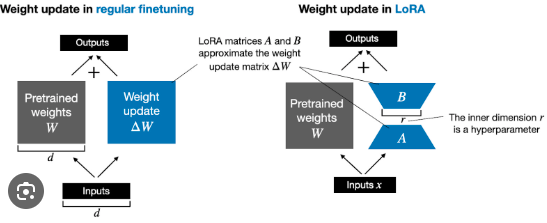

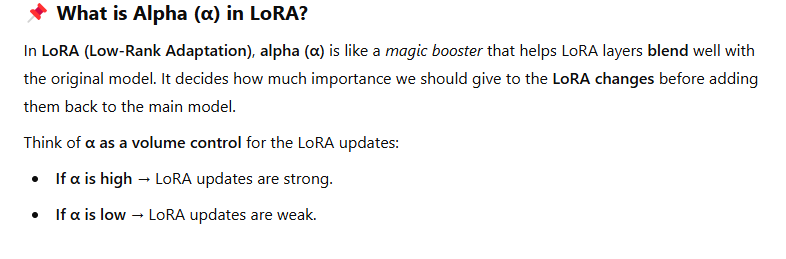

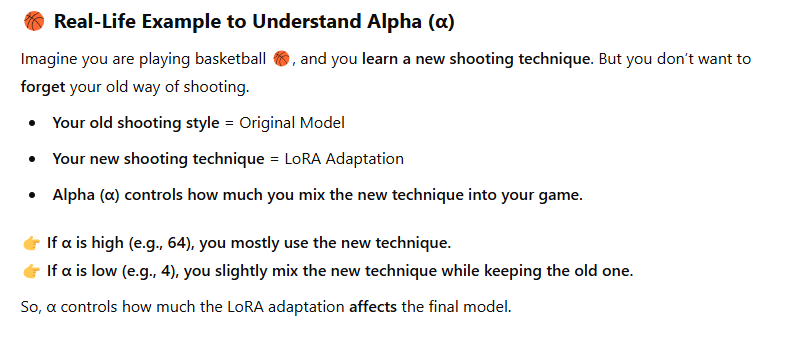

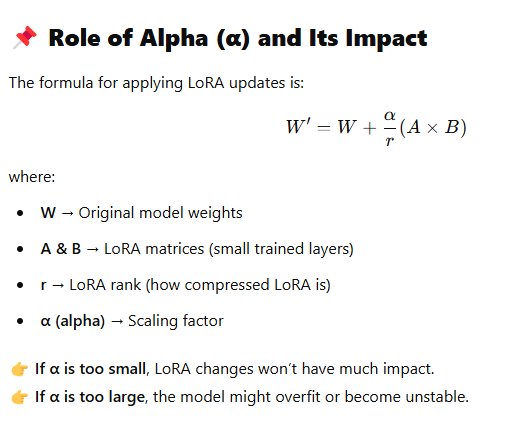

NOTE THE MAIN AIM OF THE LORA IS TO REPPLCE THE NORMAL Delta-WEIGHTS WITH 'ab'

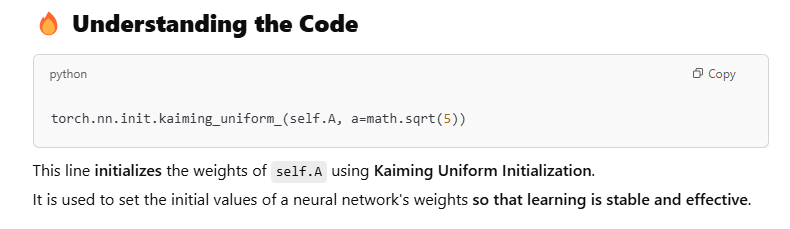

In [ ]:
import math
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))  # similar to standard weight initialization
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

In the code above, rank is a hyperparameter that controls the inner dimension of the matrices
 and
In other words, this parameter controls the number of additional parameters introduced by LoRA and is a key factor in determining the balance between model adaptability and parameter efficiency
The second hyperparameter, alpha, is a scaling hyperparameter applied to the output of the low-rank adaptation
It essentially controls the extent to which the adapted layer's output is allowed to influence the original output of the layer being adapted
This can be seen as a way to regulate the impact of the low-rank adaptation on the layer's output
So far, the LoRALayer class we implemented above allows us to transform the layer inputs
However, in LoRA, we are usually interested in replacing existing Linear layers so that the weight update is applied to the existing pretrained weights.

To incorporate the original Linear layer weights , we implement a LinearWithLoRA layer below that uses the previously implemented LoRALayer and can be used to replace existing Linear layers in a neural network, for example, the self-attention module or feed forward modules in an LLM

In [ ]:
class LinearWithLoRA(torch.nn.Module):
  def __init__(self, linear , rank , alpha ):
    super().__init__()
    self.linear = linear
    self.lora = LoRALayer(
        linear.in_features , linear.out_features , rank , alpha
    )

  def forward(self , x):
    return self.linear(x) + self.lora(x)



Note that since we initialize the weight matrix
 (self.B in LoRALayer) with zero values in the LoRA layer, the matrix multiplication between
 and
 results in a matrix consisting of 0's and doesn't affect the original weights (since adding 0 to the original weights does not modify them) <br>
lets  try LoRA on the GPT model we defined earlier, we define a replace_linear_with_lora function to replace all Linear layers in the model with the new LinearWithLoRA layers

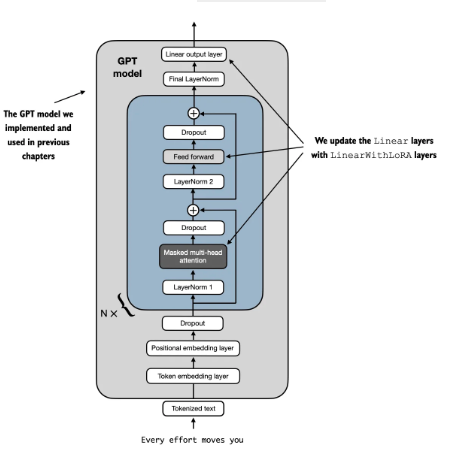

In [ ]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # Replace the Linear layer with LinearWithLoRA
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            # Recursively apply the same function to child modules
            replace_linear_with_lora(module, rank, alpha)

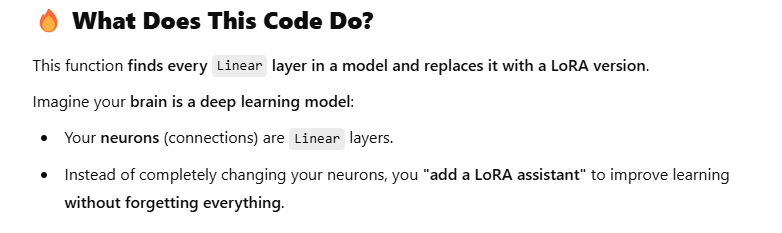

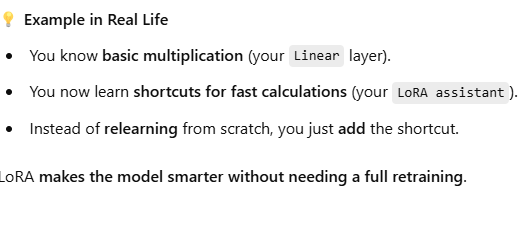


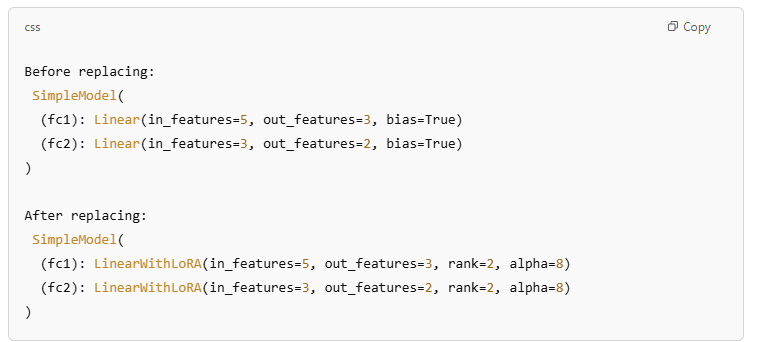

We then freeze the original model parameter and use the replace_linear_with_lora to replace the said Linear layers using the code below
This will replace the Linear layers in the LLM with LinearWithLoRA layers

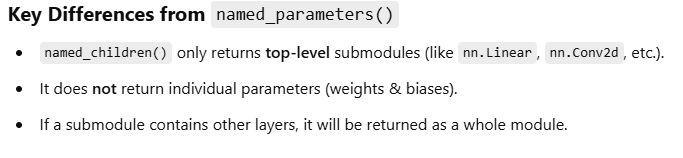

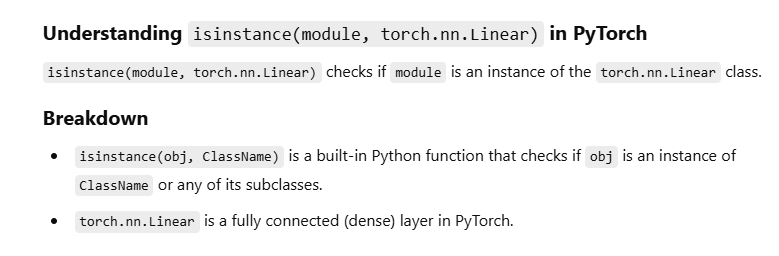

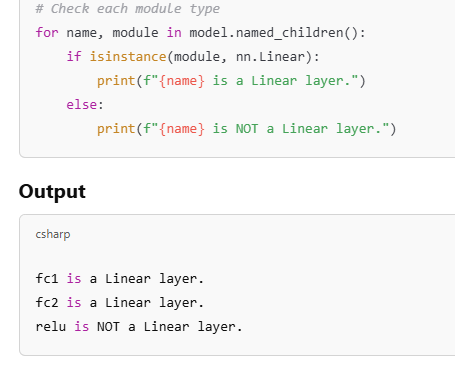

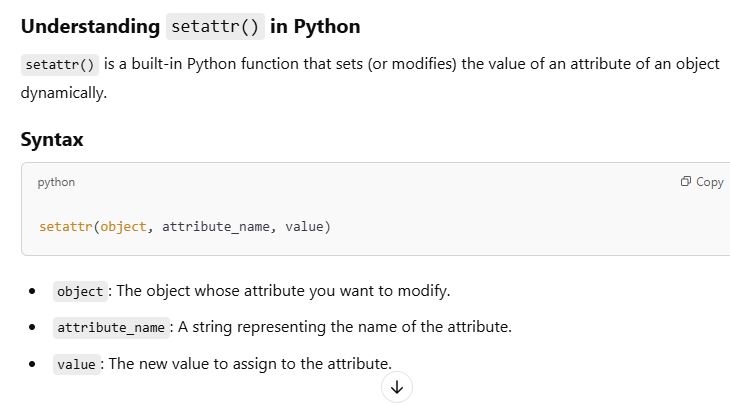

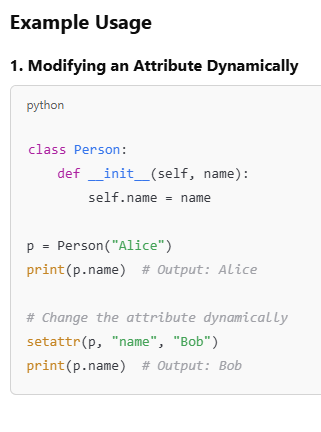

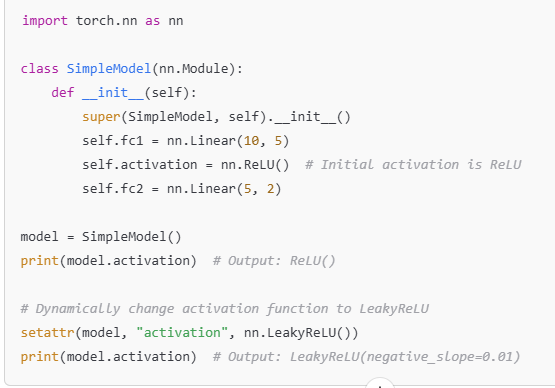

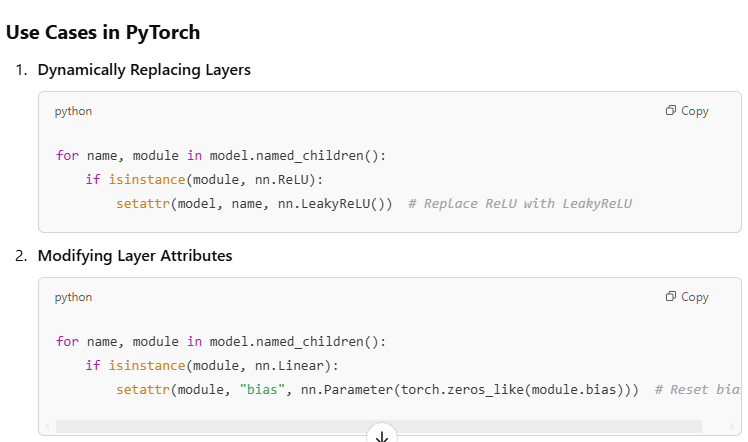

We then freeze the original model parameter and use the replace_linear_with_lora to replace the said Linear layers using the code below
This will replace the Linear layers in the LLM with LinearWithLoRA layers

In [ ]:
total_params = sum( p.numel() for p in gpt.parameters() if p.requires_grad )
print(f"Total trainable parameters before: {total_params:,}")


Total trainable parameters before: 124,441,346


In [ ]:
for param in gpt.parameters():
    param.requires_grad = False

In [ ]:
total_params = sum(p.numel() for p in gpt.parameters() if p.requires_grad )
print(f"Total trainable parameters before: {total_params:,}")


Total trainable parameters before: 0


In [ ]:
replace_linear_with_lora(gpt , rank = 16 , alpha = 16 )

In [ ]:
total_params = sum(p.numel() for p in gpt.parameters() if p.requires_grad )
print(f"Total trainable parameters before: {total_params:,}")

Total trainable parameters before: 2,666,528


In [ ]:
total_params = sum( p.numel() for p in gpt.parameters() )
print(f" total parmeters after the lora adding {total_params}")

 total parmeters after the lora adding 127107874


# ** intially 124 million parameters model -> total trainable parameters is also 124 M
<br>
# by Now as we replaced the model linear layers with linear + lora  so model size became 127 million but trainable params is 2,666,528 ie nearly 2 million **

As we can see, we reduced the number of trainable parameters by almost 50x when using LoRA
Let's now double-check whether the layers have been modified as intended by printing the model architecture


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)

print(gpt)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

# see how the query looking like

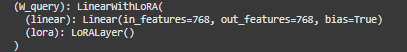

In [ ]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, gpt , device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, gpt , device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, gpt , device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


#lets lora finetune

In [ ]:
import time
from code_for_normal_classifer_built_from_scratch import train_classifier_simple


start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.820, Val loss 3.462
Ep 1 (Step 000050): Train loss 0.396, Val loss 0.364
Ep 1 (Step 000100): Train loss 0.111, Val loss 0.229
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.135, Val loss 0.073
Ep 2 (Step 000200): Train loss 0.009, Val loss 0.048
Ep 2 (Step 000250): Train loss 0.024, Val loss 0.171
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.023, Val loss 0.106
Ep 3 (Step 000350): Train loss 0.054, Val loss 0.314
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 4 (Step 000400): Train loss 0.141, Val loss 0.070
Ep 4 (Step 000450): Train loss 0.004, Val loss 0.032
Ep 4 (Step 000500): Train loss 0.001, Val loss 0.042
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.000, Val loss 0.097
Ep 5 (Step 000600): Train loss 0.007, Val loss 0.081
Training accuracy: 100.00% | Validation accuracy: 95.00%
Training completed in 103.01

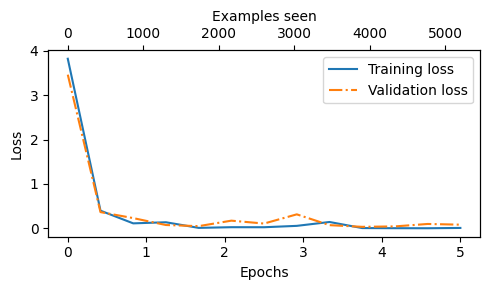

In [ ]:
from code_for_normal_classifer_built_from_scratch import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

In [ ]:

train_accuracy = calc_accuracy_loader(train_loader, gpt , device)
val_accuracy = calc_accuracy_loader(val_loader, gpt , device)
test_accuracy = calc_accuracy_loader(test_loader, gpt , device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 100.00%
Validation accuracy: 95.97%
Test accuracy: 98.67%
